# Proyecto: Técnicas para prevenir error de "Overfitting"

## En el presente código se entrena una red neuronal para que clasifique un data-set de películas de acuerdo a los comentarios (positivos o negativos) de los usuarios.

### Se iniciará con una arquitectura de red neuronal que genera "overfitting" y posteriormente construiremos nuevas aqrquitecturas que van reduciendo este error hasta lograr eliminar por completo el "overfitting"

### Se comparan resultados cuando se utilizan técnicas de reducción de 'overfitting' como:
* Regularización (con normas $L_{1}$ y $L_{2}$)

* DropOut (reducción del porcentaje de neuronas a activar en cada capa) 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

from keras.datasets import imdb

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers


In [2]:
# Imprimimos las propiedades del hardware usado por Tensorflow:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10299771185530272586
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 929955840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1319053500113484548
physical_device_desc: "device: 0, name: NVIDIA GeForce 940MX, pci bus id: 0000:02:00.0, compute capability: 5.0"
]


In [3]:
N=10000 #<-- numero de plabras

# Diccionario {'palabra_k':numero_k} correspondiente al dataset 'imdb'
word_index = imdb.get_word_index()

# cargamos datos de keras:
(train_data, train_labels), (test_data,test_labels) = imdb.load_data(num_words=N)

# 'train_data' y 'test_data' son arreglos cuyos elementos son listas de la forma:
# train_data[i] = [n0,n1,...,nk]. Cada número ni corresponde a una palabla
# por lo que cada lista 'train_data[i]' representa un comentario (texto) de una pelicula
# dicho comentario se puede decifrar usando el diccionario 'word_index'
 
# 'train_labels' y 'test_labels' son arreglos cuyos elementos son enteros 0 ó 1
# que representan una calificación negativa o positiva de una pleicula.


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/marck/.local/lib/python3.8/site-packages/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/marck/.local/lib/python3.8/site-packages/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specif

In [4]:
# Información del data set:
print('\ntype(word_index)',type(word_index)) 
print('len(word_index)',len(word_index)) 

print('\ntype(train_data)=',type(train_data))
print('train_data.shape =', train_data.shape)

print('\ntype(test_data)=',type(test_data))
print('test_data.shape =', test_data.shape)

print('\ntype(train_labels)=',type(train_labels))
print('train_labels.shape =', train_labels.shape)

print('\ntype(test_labels)=',type(test_labels))
print('test_labels.shape =', test_labels.shape)


type(word_index) <class 'dict'>
len(word_index) 88584

type(train_data)= <class 'numpy.ndarray'>
train_data.shape = (25000,)

type(test_data)= <class 'numpy.ndarray'>
test_data.shape = (25000,)

type(train_labels)= <class 'numpy.ndarray'>
train_labels.shape = (25000,)

type(test_labels)= <class 'numpy.ndarray'>
test_labels.shape = (25000,)


In [5]:
# Intercambiamos los valores y claves del diccionario 'word_index'
# ya que es de la forma {'palabla': numero}
# y lo pasaremos a la forma {numero:'palabla'}
# esto para que la RNA trabaje con números y no con palabras

# Construimos una lista de tuplas y luego la pasamos a 'dict':
word_index = dict( [ (value,key) for key,value in word_index.items() ] )

In [6]:
# Visualización de uno de los 25000 comentarios en 'train_data':

# recordemos que 'train_data[i] = [n0,n1,...,nk]' donde cada número 'ni' corresponde a una palabla
# por lo que cada lista 'train_data[i]' representa un comentario (texto) de una pelicula

i=21345 # visualizamos uno de los 25000 comentarios
for ni in train_data[i]:
    # decodificamos el contenido usando el diccionario 'word_index':       
    print( word_index.get(ni-3) )

None
my
None
rented
out
this
film
the
other
night
so
we
watched
it
together
br
br
the
first
impression
is
actually
a
positive
one
because
the
whole
movie
is
shot
in
this
colorful
grainy
post
mtv
None
fast
sequences
cool
angles
sweeping
camera
moves
for
the
moment
there
you
feel
like
you
about
to
watch
another
snatch
for
the
moment
br
br
when
the
plot
actually
starts
unfolding
one
starts
to
feel
as
if
one
over
None
None
things
just
don't
make
sense
anymore
i
would
hate
to
spoil
the
fun
of
watching
it
by
giving
out
certain
scenes
but
then
again
the
film
is
so
bad
that
you
are
actually
better
off
not
watching
it
br
br
first
you
think
it
is
a
crime
story
None
in
a
conversation
between
None
knightley
and
lucy
liu
wrong
this
conversation
provides
no
coherent
narrative
whatsoever
rather
on
the
contrary
None
lesbian
come
on
on
lucy
None
character
during
the
second
part
of
the
movie
just
throws
the
audience
into
further
confusion
br
br
then
i
thought
that
maybe
it
is
a
movie
about
a
girl
from
N

In [7]:
# Dado que las redes sólo trabajan con arreglos, 
# codificaremos la información con arreglos de valores binarios:
def vectorizar(sequences, dim=N):

    results = np.zeros( (len(sequences), dim) )

    for i, sequences in enumerate(sequences):
        results[i , sequences] = 1

    return results

In [8]:
# Codificamos datos de entrenamiento y pruebas como arreglos con valore binarios:
x_train = vectorizar(train_data, dim=N)
x_test = vectorizar(test_data, dim=N)

i=21345 # visualizamos uno de los 25000 comentarios ya codificado 
print('x_train[i]=\n',x_train[i])
print('\nx_test[i]=\n',x_test[i])

x_train[i]=
 [0. 1. 1. ... 0. 0. 0.]

x_test[i]=
 [0. 1. 1. ... 0. 0. 0.]


In [9]:
# Codificamos etiquetas de entrenamiento y pruebas como variables de tipo 'float32':
# Esto optimiza el rendimiento de la RNA
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

### Seleccionamos datos de entrenamiento, validación y pruebas:

El objetivo de esta práctica es generar 'overfitting' intencionalmente para 

posteriormente eliminarlo, así que el dataset de entrenamiento será más

pequeño que el dataset de validación

In [10]:
# features y labels entrenamiento (EN ESTE CASO sólo tomamos una parte de los datos reales):
x_train_partial = x_train[0:N , :]
y_train_partial = y_train[0:N]

# features y labels para validacion 
# (EN ESTE CASO tomamos el dataset más grande que los de entrenamiento para producir overfitting):
x_val = x_train[N: , :]
y_val = y_train[N:]


# Notemos que para los datos de entrenamiento hemos tomado los últimos N registros
# y para los datos de validación hemos tomado todos los registros.
# Así que el conjunto de datos de entrenamiento es menor que el de validación, 
# lo cual nos llevará a 'overfitting' como ya veremos a continación

print('\ntamaño de los features de entrenamiento = ',x_train_partial.shape)
print('tamaño de los labels de entrenamiento = ',y_train_partial.shape)

print('\ntamaño de los features de validación = ',x_val.shape)
print('tamaño de los labels de validación = ',y_val.shape)

print('\nHay más datos de validación que de entrenamineto, lo que producirá OverFitting!')


tamaño de los features de entrenamiento =  (10000, 10000)
tamaño de los labels de entrenamiento =  (10000,)

tamaño de los features de validación =  (15000, 10000)
tamaño de los labels de validación =  (15000,)

Hay más datos de validación que de entrenamineto, lo que producirá OverFitting!


In [11]:
# dimensión de los features para entrenar la red:
dim_feature = x_train[0].shape
dim_feature

(10000,)

# Pruebas con red neuronal 1: Red compleja (muchas conexiones)

In [12]:
# Creamos red neuronal 1:

nn1 = 16 # <-- numero de neuronas para la capa 1
nn2 = 16  # <-- numero de neuronas de la capa 2
nn3 = 1  # <-- numero de neuronas de la capa 3

# INICIALIZAMOS RED
model1 = models.Sequential() # <-- se inicializa la red

# Se van agregando las capas con sus parámetros:
model1.add( layers.Dense(nn1 ,activation='relu', input_shape =dim_feature) )# <-- capa 1 (Recibe features)
model1.add( layers.Dense(nn2, activation='relu') ) # <-- capa 2
model1.add( layers.Dense(nn3, activation='sigmoid') )#<-- capa de salida (Arroja labels predichos)

In [13]:
# visualzamos la arquitecura de la red:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [14]:
# optimizador:
nadam = tf.keras.optimizers.Nadam(learning_rate=0.001)

# compilamos la red:
model1.compile(
    optimizer= nadam, # <--- Elegimos el método de optmimización,
    loss='binary_crossentropy',# <-- función de costo recomendada para clasificación no binaria
    metrics='accuracy'
    )

In [15]:
# Entrenemos el modelo y los resultados los guardamos en 'history':
history1 = model1.fit(
    x_train_partial, 
    y_train_partial,
    epochs=20,
    batch_size=512,
    validation_data=(x_val , y_val) # <-- agregamos datos para validación
    )

Epoch 1/20
20/20 [==============================] - 2s 69ms/step - loss: 0.6312 - accuracy: 0.7147 - val_loss: 0.5192 - val_accuracy: 0.8414
Epoch 2/20
20/20 [==============================] - 1s 37ms/step - loss: 0.4172 - accuracy: 0.8810 - val_loss: 0.3771 - val_accuracy: 0.8667
Epoch 3/20
20/20 [==============================] - 1s 37ms/step - loss: 0.2789 - accuracy: 0.9186 - val_loss: 0.3112 - val_accuracy: 0.8831
Epoch 4/20
20/20 [==============================] - 1s 36ms/step - loss: 0.2004 - accuracy: 0.9434 - val_loss: 0.2972 - val_accuracy: 0.8854
Epoch 5/20
20/20 [==============================] - 1s 37ms/step - loss: 0.1510 - accuracy: 0.9617 - val_loss: 0.2920 - val_accuracy: 0.8819
Epoch 6/20
20/20 [==============================] - 1s 39ms/step - loss: 0.1166 - accuracy: 0.9724 - val_loss: 0.2977 - val_accuracy: 0.8854
Epoch 7/20
20/20 [==============================] - 1s 37ms/step - loss: 0.0916 - accuracy: 0.9810 - val_loss: 0.3109 - val_accuracy: 0.8827
Epoch 8/20
20

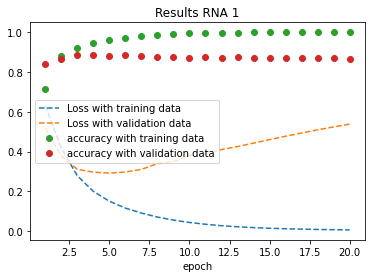

In [16]:
# visualizamos resultados:

history_dict = history1.history  # <-- extrae en 'accuracy' y 'loss' de cada 'epoch'
# history_dict = {'loss':[...], 'accuracy':[...], 'val_loss':[...], 'val_accuracy':[...] }

loss_values = history_dict['loss']# <-- valores del 'loss'
val_loss_values = history_dict['val_loss'] #<-- valores del 'loss' (para datos de validacion)
accuracy_values = history_dict['accuracy']# <-- valores del 'loss'
val_accuracy_values = history_dict['val_accuracy'] #<-- valores del 'loss' (para datos de validacion)

# numeramos 'epochs' contando desde 1:
epoch = range(1,len(loss_values)+1)

plt.figure()
plt.plot(epoch, loss_values, '--', label='Loss with training data')
plt.plot(epoch, val_loss_values, '--', label='Loss with validation data')
plt.plot(epoch, accuracy_values, 'o', label='accuracy with training data')
plt.plot(epoch, val_accuracy_values, 'o', label='accuracy with validation data')
plt.legend()
plt.title('Results RNA 1')
plt.xlabel('epoch')
plt.show()

### En la grafica anterior se puede observar overfitting:
### 'Loss' pequeño con los datos de entrenamiento y 'Loss' grande con los datos de validación,
### es decir: El modelo memorizó pero no aprendió

In [17]:
# medimos precisión del entrenamiento con los datos de prueba:
model1.evaluate(x_test,y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.5730 - accuracy: 0.8570


[0.5729575157165527, 0.8569599986076355]

# Pruebas con red neuronal 2: Red menos compleja (pocas conexiones)

In [18]:
# Creamos red neuronal 2:

nn1 = 4 # <-- numero de neuronas para la capa 1
nn2 = 4  # <-- numero de neuronas de la capa 2
nn3 = 1  # <-- numero de neuronas de la capa 3


# INICIALIZAMOS RED
model2 = models.Sequential() # <-- se inicializa la red

# Se van agregando las capas con sus parámetros:
model2.add( layers.Dense(nn1 ,activation='relu', input_shape = dim_feature) )# <-- capa 1 (Recibe features)
model2.add( layers.Dense(nn2, activation='relu') ) # <-- capa 2
model2.add( layers.Dense(nn3, activation='sigmoid') )#<-- capa de salida (Arroja labels predichos)

In [19]:
# visualzamos la arquitecura de la red:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [20]:
# optimizador:
nadam = tf.keras.optimizers.Nadam(learning_rate=0.001)

# compilamos la red:
model2.compile(
    optimizer= nadam, # <--- Elegimos el método de optmimización,
    loss='binary_crossentropy',# <-- función de costo recomendada para clasificación no binaria
    metrics='accuracy'
    )

In [21]:
# Entrenemos el modelo y los resultados los guardamos en 'history2':
history2 = model2.fit(
    x_train_partial, 
    y_train_partial,
    epochs=20,
    batch_size=512,
    validation_data=(x_val , y_val))

Epoch 1/20
20/20 [==============================] - 2s 63ms/step - loss: 0.6661 - accuracy: 0.6735 - val_loss: 0.6190 - val_accuracy: 0.7562
Epoch 2/20
20/20 [==============================] - 1s 36ms/step - loss: 0.5632 - accuracy: 0.8453 - val_loss: 0.5260 - val_accuracy: 0.8479
Epoch 3/20
20/20 [==============================] - 1s 36ms/step - loss: 0.4654 - accuracy: 0.8879 - val_loss: 0.4526 - val_accuracy: 0.8694
Epoch 4/20
20/20 [==============================] - 1s 37ms/step - loss: 0.3854 - accuracy: 0.9101 - val_loss: 0.3990 - val_accuracy: 0.8745
Epoch 5/20
20/20 [==============================] - 1s 36ms/step - loss: 0.3230 - accuracy: 0.9232 - val_loss: 0.3587 - val_accuracy: 0.8806
Epoch 6/20
20/20 [==============================] - 1s 36ms/step - loss: 0.2744 - accuracy: 0.9363 - val_loss: 0.3322 - val_accuracy: 0.8815
Epoch 7/20
20/20 [==============================] - 1s 36ms/step - loss: 0.2362 - accuracy: 0.9444 - val_loss: 0.3137 - val_accuracy: 0.8837
Epoch 8/20
20

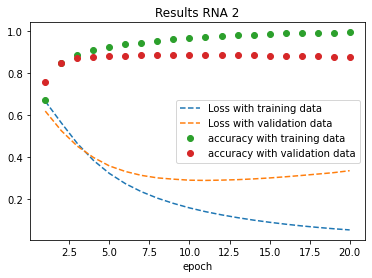

In [22]:
# visualizamos resultados:

# ========================== Grafico 1 =========================
history_dict = history2.history  # <-- extrae en 'accuracy' y 'loss' de cada 'epoch'
# history_dict = {'loss':[...], 'accuracy':[...], 'val_loss':[...], 'val_accuracy':[...] }

loss_values = history_dict['loss']# <-- valores del 'loss'
val_loss_values = history_dict['val_loss'] #<-- valores del 'loss' (para datos de validacion)
accuracy_values = history_dict['accuracy']# <-- valores del 'loss'
val_accuracy_values = history_dict['val_accuracy'] #<-- valores del 'loss' (para datos de validacion)

# numeramos 'epochs' contando desde 1:
epoch = range(1,len(loss_values)+1)

plt.figure()
plt.title('Results RNA 2')
plt.plot(epoch, loss_values, '--', label='Loss with training data')
plt.plot(epoch, val_loss_values, '--', label='Loss with validation data')
plt.plot(epoch, accuracy_values, 'o', label='accuracy with training data')
plt.plot(epoch, val_accuracy_values, 'o', label='accuracy with validation data')
plt.legend()
plt.xlabel('epoch')
plt.show()

### En la grafica anterior se puede observar overfitting:
### 'Loss' pequeño con los datos de entrenamiento y 'Loss' grande con los datos de validación

In [ ]:
# Obtenemos una medida de la precisión de las predicciones:

# Ya que se encontraron los pesos que minimizan la función de costo (se entrenó la red)
# sólo se hace una 'Forward propagation' con los datos de ptrueba para medir su aprendizaje:
ev = model2.evaluate(x_test,y_test)

# Pruebas con red neuronal 3: Red menos compleja (pocas conexiones) + Regularizadores L1-L2

In [25]:
# Creamos red neuronal 3:

nn1 = 4 # <-- numero de neuronas para la capa 1
nn2 = 4  # <-- numero de neuronas de la capa 2
nn3 = 1  # <-- numero de neuronas de la capa 3

alfa_l1 = 0.001 # <-- multiplo del regularizador l1
alfa_l2 = 0.001 # <-- multiplo del regularizador l2


# INICIALIZAMOS RED
model3 = models.Sequential() # <-- se inicializa la red

# Se van agregando las capas con sus parámetros:
model3.add( layers.Dense(nn1 ,activation='relu', input_shape =dim_feature, kernel_regularizer=regularizers.l1_l2(alfa_l1, alfa_l2)) )# <-- capa 1 (Recibe features) y hemos agregado regularizador
model3.add( layers.Dense(nn2, activation='relu', kernel_regularizer=regularizers.l1_l2(alfa_l1, alfa_l2)) ) # <-- capa 2 con regularizado
model3.add( layers.Dense(nn3, activation='sigmoid') )#<-- capa de salida (Arroja labels predichos)

In [26]:
# visualzamos la arquitecura de la red:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [27]:
# optimizador:
nadam = tf.keras.optimizers.Nadam(learning_rate=0.001)

# compilamos el modelo:
model3.compile(
    optimizer= nadam, # <--- Elegimos el método de optmimización,
    loss='binary_crossentropy',# <-- función de costo recomendada para clasificación no binaria
    metrics='accuracy'
    )

In [28]:
# Entrenemos el modelo y los resultados los guardamos en 'history3':
history3 = model3.fit(
    x_train_partial, 
    y_train_partial,
    epochs=20,
    batch_size=512,
    validation_data=(x_val , y_val))

Epoch 1/20
20/20 [==============================] - 2s 65ms/step - loss: 0.9576 - accuracy: 0.6074 - val_loss: 0.7304 - val_accuracy: 0.7973
Epoch 2/20
20/20 [==============================] - 1s 37ms/step - loss: 0.6634 - accuracy: 0.8241 - val_loss: 0.6278 - val_accuracy: 0.8385
Epoch 3/20
20/20 [==============================] - 1s 38ms/step - loss: 0.6005 - accuracy: 0.8465 - val_loss: 0.5825 - val_accuracy: 0.8459
Epoch 4/20
20/20 [==============================] - 1s 38ms/step - loss: 0.5572 - accuracy: 0.8542 - val_loss: 0.5472 - val_accuracy: 0.8507
Epoch 5/20
20/20 [==============================] - 1s 37ms/step - loss: 0.5226 - accuracy: 0.8632 - val_loss: 0.5198 - val_accuracy: 0.8541
Epoch 6/20
20/20 [==============================] - 1s 39ms/step - loss: 0.4963 - accuracy: 0.8682 - val_loss: 0.5012 - val_accuracy: 0.8547
Epoch 7/20
20/20 [==============================] - 1s 34ms/step - loss: 0.4759 - accuracy: 0.8683 - val_loss: 0.4863 - val_accuracy: 0.8579
Epoch 8/20
20

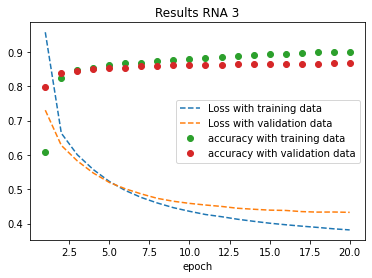

In [29]:
# visualizamos resultados:

# ========================== Grafico 1 =========================
history_dict = history3.history  # <-- extrae en 'accuracy' y 'loss' de cada 'epoch'
# history_dict = {'loss':[...], 'accuracy':[...], 'val_loss':[...], 'val_accuracy':[...] }

loss_values = history_dict['loss']# <-- valores del 'loss'
val_loss_values = history_dict['val_loss'] #<-- valores del 'loss' (para datos de validacion)
accuracy_values = history_dict['accuracy']# <-- valores del 'loss'
val_accuracy_values = history_dict['val_accuracy'] #<-- valores del 'loss' (para datos de validacion)

# numeramos 'epochs' contando desde 1:
epoch = range(1,len(loss_values)+1)

plt.figure()
plt.title('Results RNA 3')
plt.plot(epoch, loss_values, '--', label='Loss with training data')
plt.plot(epoch, val_loss_values, '--', label='Loss with validation data')
plt.plot(epoch, accuracy_values, 'o', label='accuracy with training data')
plt.plot(epoch, val_accuracy_values, 'o', label='accuracy with validation data')
plt.legend()
plt.xlabel('epoch')
plt.show()


### En la grafica anterior se puede observar que hemos reducido el overfitting:
### 'Loss' pequeño con los datos de entrenamiento y 'Loss' pequeño con los datos de validación

In [ ]:
# Obtenemos una medida de la precisión de las predicciones:

# Ya que se encontraron los pesos que minimizan la función de costo (se entrenó la red)
# sólo se hace una 'Forward propagation' con los datos de ptrueba para medir su aprendizaje:
ev = model3.evaluate(x_test,y_test)

# Pruebas con red neuronal 4: Red menos compleja (pocas conexiones) + Dropout

In [31]:
# Creamos red neuronal 4:

nn1 = 4 # <-- numero de neuronas para la capa 1
nn2 = 4  # <-- numero de neuronas de la capa 2
nn3 = 1  # <-- numero de neuronas de la capa 3

p_active = 0.5 #<-- porcentaje de neuronas a activar aleatoriamente en las capas con dropout

#alfa_l1 = 0.001 # <-- multiplo del regularizador l1
#alfa_l2 = 0.001 # <-- multiplo del regularizador l2

# INICIALIZAMOS RED
model4 = models.Sequential() # <-- se inicializa la red

# Se van agregando las capas con sus parámetros:
model4.add( layers.Dense(nn1 ,activation='relu', input_shape = dim_feature) )# <-- capa 1 (Recibe features)
model4.add( layers.Dropout(p_active) ) # hacemos "dropout" a la capa anterior
model4.add( layers.Dense(nn2, activation='relu') ) # capa 2
model4.add( layers.Dropout(p_active) ) # hacemos "dropout" a la capa anterior
model4.add( layers.Dense(nn3, activation='sigmoid')  ) # capa de salida (Arroja labels predichos)

In [32]:
# visualzamos la arquitecura de la red:
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 4)                 40004     
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 20        
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [33]:
# optimizador:
nadam = tf.keras.optimizers.Nadam(learning_rate=0.001)

model4.compile(
    optimizer= nadam, # <--- Elegimos el método de optmimización,
    loss='binary_crossentropy',# <-- función de costo recomendada para clasificación no binaria
    metrics='accuracy'
    )

In [34]:
# Entrenemos el modelo y los resultados los guardamos en 'history3':
history4 = model4.fit(
    x_train_partial, 
    y_train_partial,
    epochs=20,
    batch_size=512,
    validation_data=(x_val , y_val))

Epoch 1/20
20/20 [==============================] - 2s 65ms/step - loss: 0.6883 - accuracy: 0.5145 - val_loss: 0.6641 - val_accuracy: 0.7109
Epoch 2/20
20/20 [==============================] - 1s 37ms/step - loss: 0.6545 - accuracy: 0.5551 - val_loss: 0.5966 - val_accuracy: 0.8303
Epoch 3/20
20/20 [==============================] - 1s 36ms/step - loss: 0.6140 - accuracy: 0.6223 - val_loss: 0.5617 - val_accuracy: 0.8469
Epoch 4/20
20/20 [==============================] - 1s 37ms/step - loss: 0.5859 - accuracy: 0.6814 - val_loss: 0.5153 - val_accuracy: 0.8591
Epoch 5/20
20/20 [==============================] - 1s 37ms/step - loss: 0.5703 - accuracy: 0.7038 - val_loss: 0.4851 - val_accuracy: 0.8746
Epoch 6/20
20/20 [==============================] - 1s 36ms/step - loss: 0.5471 - accuracy: 0.7067 - val_loss: 0.4648 - val_accuracy: 0.8803
Epoch 7/20
20/20 [==============================] - 1s 36ms/step - loss: 0.5341 - accuracy: 0.6681 - val_loss: 0.4456 - val_accuracy: 0.8819
Epoch 8/20
20

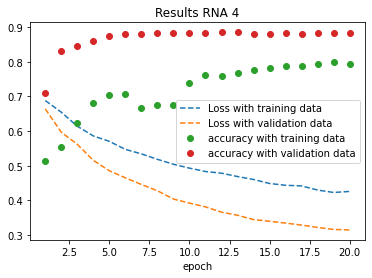

In [35]:
# visualizamos resultados:

# ========================== Grafico 1 =========================
history_dict = history4.history  # <-- extrae en 'accuracy' y 'loss' de cada 'epoch'
# history_dict = {'loss':[...], 'accuracy':[...], 'val_loss':[...], 'val_accuracy':[...] }

loss_values = history_dict['loss']# <-- valores del 'loss'
val_loss_values = history_dict['val_loss'] #<-- valores del 'loss' (para datos de validacion)
accuracy_values = history_dict['accuracy']# <-- valores del 'loss'
val_accuracy_values = history_dict['val_accuracy'] #<-- valores del 'loss' (para datos de validacion)

# numeramos 'epochs' contando desde 1:
epoch = range(1,len(loss_values)+1)

plt.figure()
plt.title('Results RNA 4')
plt.plot(epoch, loss_values, '--', label='Loss with training data')
plt.plot(epoch, val_loss_values, '--', label='Loss with validation data')
plt.plot(epoch, accuracy_values, 'o', label='accuracy with training data')
plt.plot(epoch, val_accuracy_values, 'o', label='accuracy with validation data')
plt.legend()
plt.xlabel('epoch')
plt.show()


### En la grafica anterior se puede observar que hemos eliminado completamente el overfitting:
### 'Loss' pequeño con los datos de entrenamiento y 'Loss' pequeño con los datos de validación

In [36]:
# Obtenemos una medida de la precisión de las predicciones:

# Ya que se encontraron los pesos que minimizan la función de costo (se entrenó la red)
# sólo se hace una 'Forward propagation' con los datos de ptrueba para medir su aprendizaje:
ev = model4.evaluate(x_test,y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.3279 - accuracy: 0.8762


In [37]:
# Obtenemos las etiquetas predichas con los datos de prueba: 
y_predict = model4.predict(x_test)

y_predict.shape

(25000, 1)

In [38]:
# Predecimos algun valor:
i = 17293#<--- indice del valor a predecir (< 25000)

l_obs  = y_test[i]
l_aprx = np.round(y_predict[i])

print('\nEtiqueta real: ', test_labels[i] )
print('    Etiqueta real (codificada): ', l_obs )
print('Etiqueta predicha (codificada): ', l_aprx )


Etiqueta real:  0
    Etiqueta real (codificada):  0.0
Etiqueta predicha (codificada):  [0.]


## Ejemplo de acceso a información en diccionarios:

`D = {'amarillo':1, 'rojo':2 , 'azul':3}`

Accesamos a los elememntos, mediante: 

`D.items()` 

sale: `dict_items([('amarillo', 1), ('rojo', 2), ('azul', 3)])`

Accesamos a las llaves, mediante:

`D.keys()`

sale: `dict_keys(['amarillo', 'rojo', 'azul'])`

Accesamos a los valores, mediante:

`D.values()`

sale: `dict_values([1, 2, 3])`

Podemos intercambiar el contenido del diccionario, mediante:

`D2 = dict( [(value,key)  for key, value in D.items()] )`

sale: `{1: 'amarillo', 2: 'rojo', 3: 'azul'}`